In [1]:
using Flux, Plots, LaTeXStrings, Random, ProgressMeter
using Flux: train!
using DelimitedFiles, CSV
using Statistics
scalefontsizes(1.5)
# scalefontsizes(2)

In [2]:
# data = readdlm("PendulamResults_CentralDifference_1000Points.txt", '\t', Float64, '\n');
data = readdlm("PendulamResults_2000Points.txt", '\t', Float64, '\n');

t = data[:,1];
phi = data[:,2];
# phi_dot = data[:,3];

x_train = t[1:300];
y_train = phi[1:300];

x_test = t[301:end];
y_test = phi[301:end];

x_residual = LinRange(0,2,length(x_train));
order = randperm(length(x_residual));
x_residual = x_residual[order];

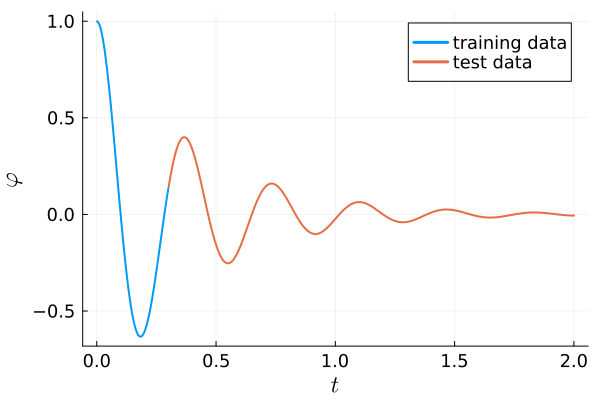

In [7]:
default(linewidth=2)
plot(x_train, y_train, label="training data")
plot!(x_test, y_test, label="test data")
# vline!([x_test[1]], label="")
# scatter!(x_train, y_train, label="training data")
xlabel!(L"t")
ylabel!(L"$\varphi$")

# savefig("data.svg")

In [4]:
# function for the residual of the equation
fd1(f, x) = (f(x.+1e-4) .- f(x.-1e-4)) ./ 2e-4;
fd2(f, x) = (fd1(f, x.+2e-4) .- fd1(f, x.-2e-4)) ./ 4e-4;
residual(model, x) = mean((fd2(model,x) .+ 5 .* fd1(model,x) .+ 300 .* model(x)).^2);

In [5]:
function train_model(model)

    loader = Flux.DataLoader((transpose(x_train), transpose(y_train)), batchsize=64, shuffle=true);
    optim = Flux.setup(Flux.Adam(0.01), model) 

    epochs = 8000

    train_mse = []
    test_mse = []
    @showprogress for epoch in 1:epochs
        for (x, y) in loader
            loss, grads = Flux.withgradient(model) do m
                # Evaluate model and loss inside gradient context:
                mse = Flux.Losses.mse(m(transpose(x_train)), transpose(y_train))
                r = residual(m, transpose(x_residual))
                mse + 0.001*r
            end
            Flux.update!(optim, model, grads[1])
        end
        push!(train_mse, Flux.Losses.mse(model(transpose(x_train)), transpose(y_train)))
        push!(test_mse, Flux.Losses.mse(model(transpose(x_test)), transpose(y_test)))
    end
    
    return (train_mse, test_mse)
    
end

train_model (generic function with 1 method)

In [6]:
# train an example model

model = Chain(
    Dense(1 => 10, tanh),
    Dense(10 => 10, tanh),
    Dense(10 => 1)
);

(train_mse, test_mse) = train_model(model);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:44m


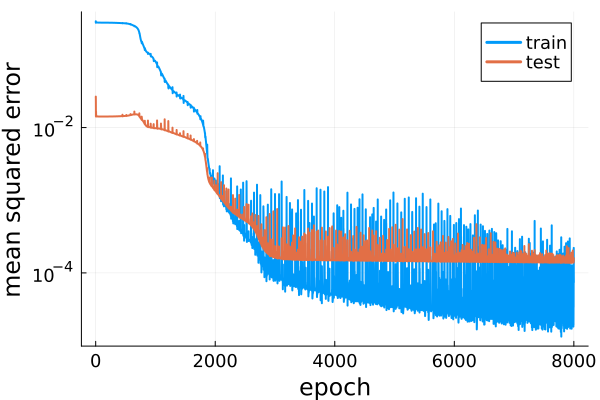

In [8]:
plot(1:length(train_mse), train_mse[1:end], label="train", yaxis=:log)
plot!(1:length(train_mse), test_mse[1:end], label="test", yaxis=:log)
xlabel!("epoch")
ylabel!("mean squared error")
# savefig("training.svg")

from the above plot one can see that the model does not overfit as the test mse never increases again. This means that the split into test and validation set is not necessary, one train and one test set is enough. This result also makes sense as the reason for overfittment is usually that the model models noise in the data. Since we have no noise, the model does not overfit.

There are however large local fluctuations in the mse during training. Also, different train runs produce much different mse in the end. This makes it really hard to compare different models against each other.

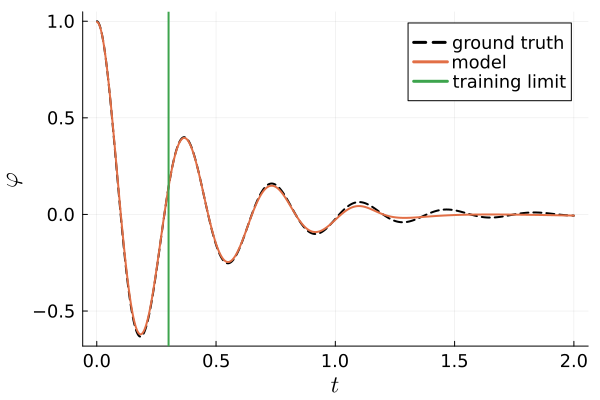

In [9]:
plot(t, phi, label="ground truth", color="black", linestyle=:dash, legend=:topright)
# scatter!(x_train, y_train, label="training data")
xlabel!(L"$t$")
ylabel!(L"$\varphi$")
plot!(t, model(transpose(t))[1,:], label="model")
vline!([x_test[1]], label="training limit")
# savefig(".svg")

In [39]:
mses = []
model_names = []
for layer_size in [[5, 5], [10,10], [50,50]]
    layer1_size = layer_size[1]
    layer2_size = layer_size[2]
    model = Chain(
        Dense(1 => layer1_size, tanh),
        Dense(layer1_size => layer2_size, tanh),
        Dense(layer2_size => 1)
    );
    model_name = "(" * string(layer1_size) * ", " * string(layer2_size) * ")"

    (train_mse, test_mse) = train_model(model);
    push!(mses, minimum(test_mse));
    push!(model_names, model_name);
end


Progress: 100%|█████████████████████████████████████████| Time: 0:00:37
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16
Progress: 100%|█████████████████████████████████████████| Time: 0:09:42


In [40]:
times = [36, 61, 9*60 + 13];

In [50]:

bar(model_names, times, label="")
# bar(model_names, mses, label="")

xlabel!("Layer size")
ylabel!("training time in s")
# savefig("layersize_time.svg")

"C:\\Users\\jonas\\Desktop\\cie\\layersize_time.svg"

the plot above is super unreliable. Repeating the same thing can result in a completely different plot

In [29]:
mses = Dict()
for activation in [relu, leakyrelu, elu, sigmoid, tanh]
    model = Chain(
        Dense(1 => 10, activation),
        Dense(10 => 10, activation),
        Dense(10 => 1)
    );
    model_name = string(activation)

    (train_mse, test_mse) = train_model(model);
    mses[model_name] = minimum(test_mse)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


In [31]:
bar(mses, label="", yaxis=:log)
xlabel!("activation function")
ylabel!("mse after training")
# savefig("activation.svg")

"C:\\Users\\jonas\\Desktop\\cie\\activation.svg"